# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from xgboost import XGBClassifier


In [2]:
RANDOM_SEED = 42

# Loading Data

In [3]:
kaggle = "KAGGLE" in "".join(os.environ.keys())

In [4]:
if kaggle:
    train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
    test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
    greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
else:
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    greeks = pd.read_csv("data/greeks.csv")

# Data Pipeline

## Preliminaries

Label encode the `EJ` column

In [5]:
train["EJ"].replace({"A": 0, "B": 1}, inplace=True)
test["EJ"].replace({"A": 0, "B": 1}, inplace=True)

Drop extra columns:

In [6]:
train_id = train["Id"]
test_id = test["Id"]
y = train["Class"]

train = train.drop(["Class"], axis=1)
train = train.drop(["Id"], axis=1)
test  = test.drop(["Id"], axis=1)

Create the columns for imputation:

In [7]:
train_null_columns = list(train.columns[train.isna().sum() != 0])
test_null_columns = list(test.columns[test.isna().sum() != 0])

In [8]:
thresh = 20000
train_columns_to_fill_via_mean = []
train_columns_to_fill_via_knn = []

null_count = train[train_null_columns].isna().sum()
for column in train_null_columns:
    if null_count[column] <= thresh:
        train_columns_to_fill_via_mean.append(column)
    else:
        train_columns_to_fill_via_knn.append(column)

print("Train columns with mean" ,train_columns_to_fill_via_mean)
print("Train columns with knn", train_columns_to_fill_via_knn)

Train columns with mean ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']
Train columns with knn []


In [9]:
thresh = 20000
test_columns_to_fill_via_mean = []
test_columns_to_fill_via_knn = []

null_count = test[test_null_columns].isna().sum()
for column in test_null_columns:
    if null_count[column] <= thresh:
        test_columns_to_fill_via_mean.append(column)
    else:
        test_columns_to_fill_via_knn.append(column)

print("test columns with mean" ,test_columns_to_fill_via_mean)
print("test columns with knn", test_columns_to_fill_via_knn)

test columns with mean []
test columns with knn []


## Pipelines

Now, the column transformations:

In [10]:
simple_imputer = SimpleImputer(strategy="mean")
knn_imputer = KNNImputer(n_neighbors=5)

train_imputer = ColumnTransformer(
    [
        ("mean_imputer", simple_imputer, train_columns_to_fill_via_mean),
        ("knn_imputer", knn_imputer, train_columns_to_fill_via_knn),
    ],
    remainder="passthrough",
)

test_imputer = ColumnTransformer(
    [
        ("mean_imputer", simple_imputer, test_columns_to_fill_via_mean),
        ("knn_imputer", knn_imputer, test_columns_to_fill_via_knn),
    ],
    remainder="passthrough",
)

standard_scaler = StandardScaler()
power_transformer = PowerTransformer()

train_scaling_pipe = Pipeline(
    [
        ("standard_scaler", standard_scaler),
        ("power_transformer", power_transformer),
    ],
)
standard_scaler_ = StandardScaler()
power_transformer_ = PowerTransformer()

test_scaling_pipe = Pipeline(
    [
        ("standard_scaler", standard_scaler_),
        ("power_transformer", power_transformer_),
    ],
)

And the final data preprocessor:

In [11]:
train_final_preprocessing_pipe = Pipeline([
    ("imputer", train_imputer),
    ("scaling_pipe", train_scaling_pipe)
])

test_final_preprocessing_pipe = Pipeline([
    ("imputer", test_imputer),
    ("scaling_pipe", test_scaling_pipe)
])

train_final_preprocessing_pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mean_imputer',
                                                  SimpleImputer(),
                                                  ['BQ', 'CB', 'CC', 'DU', 'EL',
                                                   'FC', 'FL', 'FS', 'GL']),
                                                 ('knn_imputer', KNNImputer(),
                                                  [])])),
                ('scaling_pipe',
                 Pipeline(steps=[('standard_scaler', StandardScaler()),
                                 ('power_transformer', PowerTransformer())]))])

In [12]:
test_final_preprocessing_pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mean_imputer',
                                                  SimpleImputer(), []),
                                                 ('knn_imputer', KNNImputer(),
                                                  [])])),
                ('scaling_pipe',
                 Pipeline(steps=[('standard_scaler', StandardScaler()),
                                 ('power_transformer', PowerTransformer())]))])

In [13]:
train_final_preprocessing_pipe[1] == test_final_preprocessing_pipe[1]

False

Excellent! Now, we will create the dataset to be trained:

In [14]:
X = train_final_preprocessing_pipe.fit_transform(train)
test_final = test_final_preprocessing_pipe.fit_transform(test)

In [15]:
y = y.values

In [16]:
np.isnan(X).sum()

0

We will make sure that both the training and test sets have the same number of columns:

In [17]:
assert X.shape[1] == test_final.shape[1]

## Train Test Split

Great Let's do a train test split:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper Functions  

We will create some helper functions to help us train and evaluate our models:

In [19]:
def balanced_log_loss(y_true, y_hat):
    """
    Compute the balanced log loss between y_true and y_hat.

    Parameters:
    y_true (array-like): True labels of shape (n_samples, n_classes).
    y_hat (array-like): Predicted probabilities of shape (n_samples, n_classes).

    Returns:
    float: The balanced log loss between y_true and y_hat.
    """
    eps = 1e-15
    y_hat = np.clip(y_hat, eps, 1 - eps)
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_hat, pd.Series):
        y_hat = y_hat.values
    
    y_true = y_true.astype(int)
    N0 = np.sum(y_true == 0)
    N1 = np.sum(y_true == 1)
    w0 = 1/N0
    w1 = 1/N1
    yhat0 = y_hat[:, 0]
    yhat1 = y_hat[:, 1]
    loss0 = -w0 * np.sum((1 -y_true) * np.log(yhat0))
    loss1 = -w1 * np.sum((y_true) * np.log(yhat1))
    return (loss0 + loss1)/2

In [20]:
def cm_to_metrics(cm):
    """Calculate accuracy, precision, recall and f1 score from confusion matrix.

    Parameters
    ----------
    cm : array-like
        Confusion matrix.

    Returns
    -------
    accuracy : float
        Accuracy score.
    precision : float
        Precision score.
    recall : float
        Recall score.
    f1 : float
        F1 score.
    """
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1


def evaluate_model(
    model,
    on="train",
    plot_cmat=False,
    verbose=True,
):
    """
    This function evaluates a model and returns the metrics.
    It can be used to evaluate the model on the training set or the test set.
    It can also plot the confusion matrix.
    Parameters
    ----------
    model : object
        The model to be evaluated.
    on : str, optional
        The set on which the model will be evaluated. The default is "train".
    plot_cmat : bool, optional
        Whether to plot the confusion matrix. The default is False.
    verbose : bool, optional
        Whether to print the metrics. The default is True.

    Returns
    -------
    result : dict
        A dictionary with the metrics.

    Example
    -------
    >>> result = evaluate_model(model)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}

    >>> result = evaluate_model(model, on="test")
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}

    >>> result = evaluate_model(model, plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}

    >>> result = evaluate_model(model, on="test", plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    """
    if on == "train":
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy, precision, recall, f1 = cm_to_metrics(cm)
    auc_score = roc_auc_score(y, y_pred)
    y_pred_prob = model.predict_proba(X)
    balanced_ll = balanced_log_loss(y, y_pred_prob)
    

    if plot_cmat:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["1", "0"]
        )
        disp.plot()
        plt.show()
    if verbose:
        try:
            model_name = model.__class__.__name__
        except:
            model_name = ""
        print(f"Accuracy on {on} set of the model {model_name}: {accuracy:.4f}")
        print(f"Log Loss on {on} set of the model {model_name}: {balanced_ll:.4f}")
        print(f"Precision on {on} set of the model {model_name}: {precision:.4f}")
        print(f"Recall on {on} set of the model {model_name}: {recall:.4f}")
        print(f"F1 on {on} set of the model {model_name}: {f1:.4f}")
        print(f"AUC on {on} set of the model {model_name}: {auc_score:.4f}\n")
        cr = classification_report(y, y_pred)
        print(cr)
    result = {
        "accuracy": accuracy,
        "log_loss": balanced_ll,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
    }
    return result

In [21]:
def train_cv(model, cv, scorer=balanced_log_loss):
    """
    This function trains a model using cross-validation.
    Parameters
    ----------
    model : object
        The model to be trained.
    cv : object
        A cross-validation object.

    Returns
    -------
    models : list
        A list of the trained models.
    """
    train_scores = []
    test_scores = []
    for X_train, y_train, X_test, y_test in cv:
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_train)
        train_score = scorer(y_train, y_pred)
        train_scores.append(train_score)
        y_pred = model.predict_proba(X_test)
        test_score = scorer(y_test, y_pred)
        test_scores.append(test_score)
    return train_scores, test_scores

In [22]:
def create_and_train_model(model, params, cv, scorer=balanced_log_loss):
    """
    This function creates and trains a model using cross-validation.
    Parameters
    ----------
    model : object
        The model to be trained.
    params : dict
        The parameters of the model.
    cv : object
        A cross-validation object.

    Returns
    -------
    models : list
        A list of the trained models.
    """
    best_score = 0
    for param in params:
        model.set_params(**param)
        train_scores, test_scores = train_cv(model, cv, scorer=scorer)
        models.append((model, train_scores, test_scores))
    return models

# Individual Models

In [23]:
one_weight = 1/y.mean()
zero_weight = 1/(1- y.mean())
class_weight = {0:1, 1:one_weight/zero_weight}
class_weight

{0: 1, 1: 4.712962962962963}

In [24]:
svc_best_params = {
    "C": 0.1,
    "kernel": "rbf",
    "probability": True,
    "class_weight": class_weight,
}

rf_best_params = {
    "n_estimators": 180,
    "max_depth": 4,
    "min_samples_split": 3,
    "min_samples_leaf": 2,
    "class_weight": class_weight,
}

xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "gamma": 0.1,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "scale_pos_weight": class_weight[1],
}

cat_best_params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 0.5,
    "colsample_bylevel": 0.5,
    "l2_leaf_reg": 0.1,
    "scale_pos_weight": class_weight[1],
}

## SVC

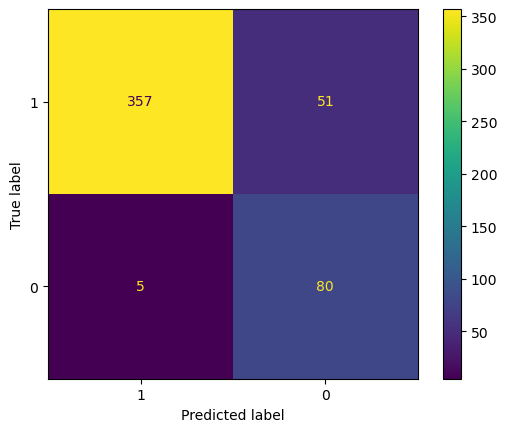

Accuracy on train set of the model SVC: 0.8864
Log Loss on train set of the model SVC: 0.2530
Precision on train set of the model SVC: 0.6107
Recall on train set of the model SVC: 0.9412
F1 on train set of the model SVC: 0.7407
AUC on train set of the model SVC: 0.9081

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       408
           1       0.61      0.94      0.74        85

    accuracy                           0.89       493
   macro avg       0.80      0.91      0.83       493
weighted avg       0.92      0.89      0.90       493



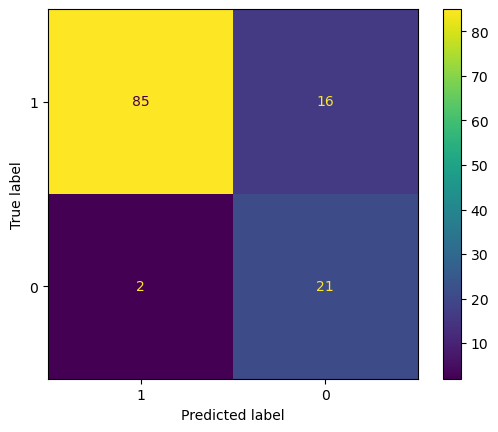

Accuracy on test set of the model SVC: 0.8548
Log Loss on test set of the model SVC: 0.3510
Precision on test set of the model SVC: 0.5676
Recall on test set of the model SVC: 0.9130
F1 on test set of the model SVC: 0.7000
AUC on test set of the model SVC: 0.8773

              precision    recall  f1-score   support

           0       0.98      0.84      0.90       101
           1       0.57      0.91      0.70        23

    accuracy                           0.85       124
   macro avg       0.77      0.88      0.80       124
weighted avg       0.90      0.85      0.87       124



In [25]:
svc = SVC(**svc_best_params)
svc.fit(X_train, y_train)
svc_result_train = evaluate_model(svc, plot_cmat=True)
svc_result_test = evaluate_model(svc, plot_cmat=True, on = "test")

## Random Forest

In [26]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED, **rf_best_params)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4.712962962962963}, max_depth=4,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=180, random_state=42)

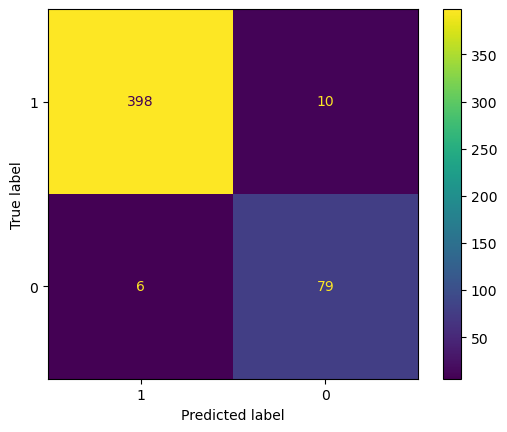

Accuracy on train set of the model RandomForestClassifier: 0.9675
Log Loss on train set of the model RandomForestClassifier: 0.2740
Precision on train set of the model RandomForestClassifier: 0.8876
Recall on train set of the model RandomForestClassifier: 0.9294
F1 on train set of the model RandomForestClassifier: 0.9080
AUC on train set of the model RandomForestClassifier: 0.9525

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       408
           1       0.89      0.93      0.91        85

    accuracy                           0.97       493
   macro avg       0.94      0.95      0.94       493
weighted avg       0.97      0.97      0.97       493



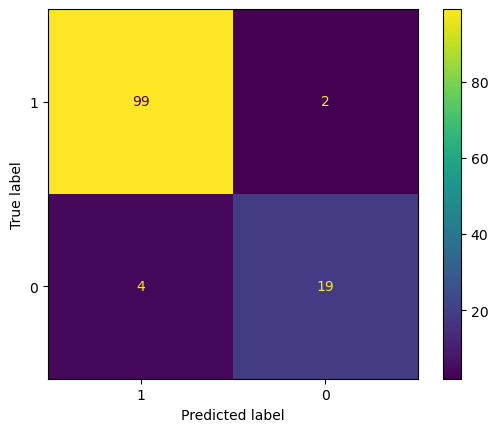

Accuracy on test set of the model RandomForestClassifier: 0.9516
Log Loss on test set of the model RandomForestClassifier: 0.3996
Precision on test set of the model RandomForestClassifier: 0.9048
Recall on test set of the model RandomForestClassifier: 0.8261
F1 on test set of the model RandomForestClassifier: 0.8636
AUC on test set of the model RandomForestClassifier: 0.9031

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       101
           1       0.90      0.83      0.86        23

    accuracy                           0.95       124
   macro avg       0.93      0.90      0.92       124
weighted avg       0.95      0.95      0.95       124



In [27]:
rfc_result_train = evaluate_model(rfc, plot_cmat=True)
rfc_result_test = evaluate_model(rfc, plot_cmat=True, on = "test")

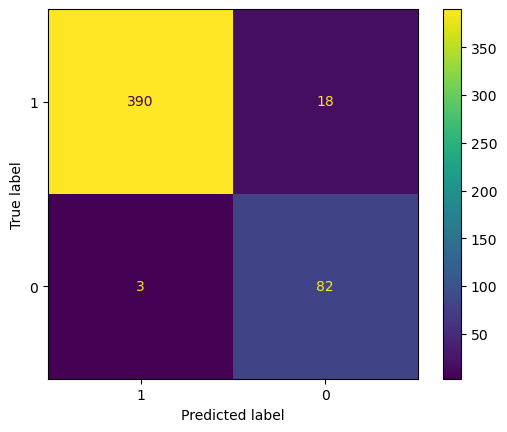## Catboost

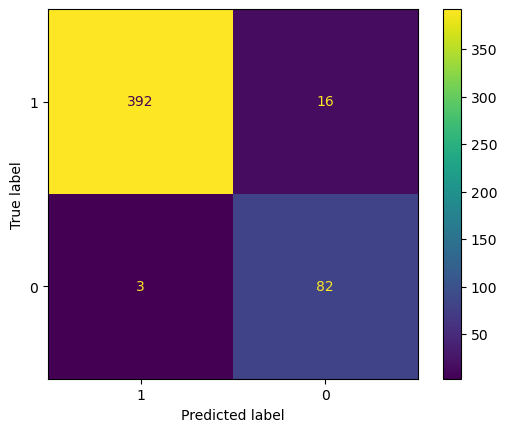

Accuracy on train set of the model CatBoostClassifier: 0.9615
Log Loss on train set of the model CatBoostClassifier: 0.1758
Precision on train set of the model CatBoostClassifier: 0.8367
Recall on train set of the model CatBoostClassifier: 0.9647
F1 on train set of the model CatBoostClassifier: 0.8962
AUC on train set of the model CatBoostClassifier: 0.9627

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       408
           1       0.84      0.96      0.90        85

    accuracy                           0.96       493
   macro avg       0.91      0.96      0.94       493
weighted avg       0.97      0.96      0.96       493



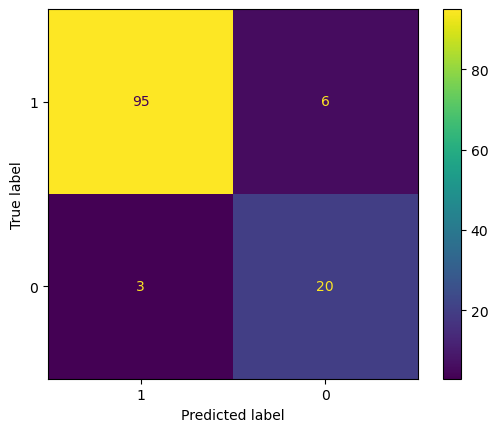

Accuracy on test set of the model CatBoostClassifier: 0.9274
Log Loss on test set of the model CatBoostClassifier: 0.2855
Precision on test set of the model CatBoostClassifier: 0.7692
Recall on test set of the model CatBoostClassifier: 0.8696
F1 on test set of the model CatBoostClassifier: 0.8163
AUC on test set of the model CatBoostClassifier: 0.9051

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       101
           1       0.77      0.87      0.82        23

    accuracy                           0.93       124
   macro avg       0.87      0.91      0.89       124
weighted avg       0.93      0.93      0.93       124



In [28]:
catc = CatBoostClassifier(random_state=RANDOM_SEED, verbose = 0, **cat_best_params)
catc.fit(X_train, y_train)
catc_result_train = evaluate_model(catc, plot_cmat=True)
catc_result_test = evaluate_model(catc, plot_cmat=True, on = "test")

## XGBoost

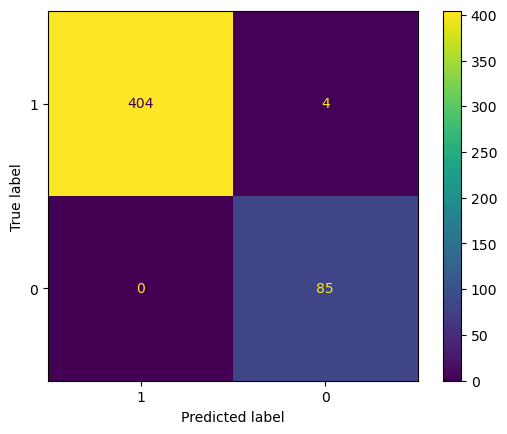

Accuracy on train set of the model XGBClassifier: 0.9919
Log Loss on train set of the model XGBClassifier: 0.1020
Precision on train set of the model XGBClassifier: 0.9551
Recall on train set of the model XGBClassifier: 1.0000
F1 on train set of the model XGBClassifier: 0.9770
AUC on train set of the model XGBClassifier: 0.9951

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       408
           1       0.96      1.00      0.98        85

    accuracy                           0.99       493
   macro avg       0.98      1.00      0.99       493
weighted avg       0.99      0.99      0.99       493



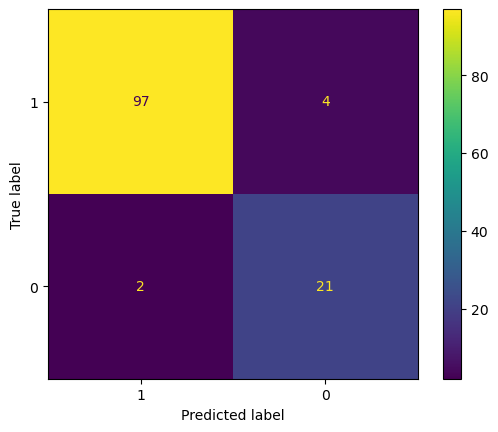

Accuracy on test set of the model XGBClassifier: 0.9516
Log Loss on test set of the model XGBClassifier: 0.2479
Precision on test set of the model XGBClassifier: 0.8400
Recall on test set of the model XGBClassifier: 0.9130
F1 on test set of the model XGBClassifier: 0.8750
AUC on test set of the model XGBClassifier: 0.9367

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       101
           1       0.84      0.91      0.87        23

    accuracy                           0.95       124
   macro avg       0.91      0.94      0.92       124
weighted avg       0.95      0.95      0.95       124



In [29]:
xgbc = XGBClassifier(random_state=RANDOM_SEED, **xgb_best_params)
xgbc.fit(X_train, y_train)
xgbc_result_train = evaluate_model(xgbc, plot_cmat=True)
xgbc_result_test = evaluate_model(xgbc, plot_cmat=True, on = "test")

# Ensemble

In [30]:
def evaluate_ensemble(models, X, y, voting="soft"):
    """Evaluates an ensemble of models on a given dataset.

    Parameters
    ----------
    models : list of models
        The list of models to evaluate.
    X : array-like of shape (n_samples, n_features)
        The input samples.
    y : array-like of shape (n_samples,)
        The target values.
    voting : str, default="soft"
        The type of voting to use. Can be either "soft" or "hard".

    Returns
    -------
    preds : ndarray of shape (n_samples,)
        The ensemble predictions.
    """
    # Initialize an array to store the predictions for each model
    preds = np.zeros((len(models), len(X)))

    # Make predictions for each model
    for i, model in tqdm(enumerate(models), "Predicting..."):
        if voting == "soft":
            preds[i] = model.predict_proba(X)[:, 1]
        else:
            preds[i] = model.predict(X)

    # Compute the ensemble prediction based on the voting type
    preds = np.round(np.mean(preds, axis=0))

    # Compute the accuracy of the ensemble prediction
    acc = np.mean(preds == y)
    cr = classification_report(y, preds)
    cm = confusion_matrix(y, preds)
    print(f"Accuracy of the ensemble: {acc:.4f}")
    print(cr)
    disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["1", "0"]
        )
    disp.plot()
    plt.show()

    return preds, acc

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
# create the EnsembleVoteClassifier object, giving the class_weight parameter
dtc = DecisionTreeClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=2,
    max_features="log2",
    min_samples_leaf=10,
    min_samples_split=10,
    splitter="random",
)

rfc = RandomForestClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=30,
    min_samples_leaf=14,
    min_samples_split=12,
    n_estimators=400,
)

xgbc = XGBClassifier(
    scale_pos_weight=7,
    max_depth=3,
    n_estimators=4,
    min_child_weight=15,
)

catc = CatBoostClassifier(
    class_weights=[1, 7],
    l2_leaf_reg=5,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=40,
    verbose = False,
)


models = [
          dtc, 
          rfc, 
          catc, 
          xgbc
         ]
for model in models:
    model.fit(X_train, y_train)

# vc.fit(X_train, y_train)

In [33]:
vc = VotingClassifier(
    estimators=[
        ("xgbc", xgbc),
        ("rfc", rfc),
        ("catc", catc),
        ("dtc", dtc),
    ],
    voting="soft",
    weights=[3, 2, 2.2, 1],
)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r...
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=30,
                                                     min_samples_leaf=14,
                                                     min_samples_split=12,
                                                     n_estimators=400)),
                             ('catc',
                              <catboost.core.CatBoostClassifier object at 0x7ab9e8501fc0>),
                             ('dtc',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features='log2',
                                                     min_samples_leaf=10,
                                                     min_samples_split=10,
                                                     splitter='random'))],
                 voting='soft', weights=[3, 2, 2.2, 1])

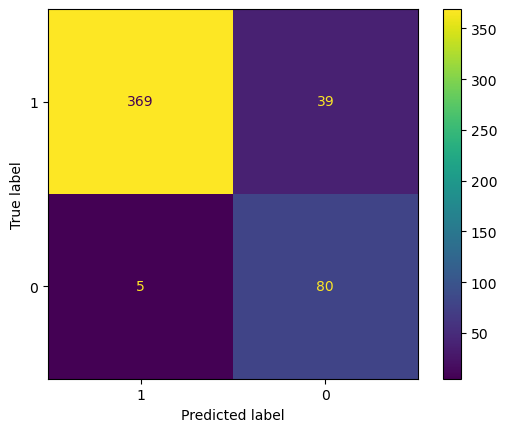

Accuracy on train set of the model VotingClassifier: 0.9108
Log Loss on train set of the model VotingClassifier: 0.3489
Precision on train set of the model VotingClassifier: 0.6723
Recall on train set of the model VotingClassifier: 0.9412
F1 on train set of the model VotingClassifier: 0.7843
AUC on train set of the model VotingClassifier: 0.9228

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       408
           1       0.67      0.94      0.78        85

    accuracy                           0.91       493
   macro avg       0.83      0.92      0.86       493
weighted avg       0.93      0.91      0.92       493



{'accuracy': 0.9107505070993914,
 'log_loss': 0.34890472944889434,
 'precision': 0.6722689075630253,
 'recall': 0.9411764705882353,
 'f1': 0.7843137254901961,
 'auc': 0.9227941176470589}

In [34]:
evaluate_model(vc, "train", True)

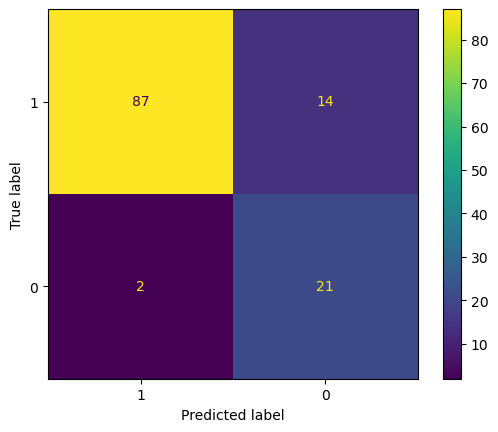

Accuracy on test set of the model VotingClassifier: 0.8710
Log Loss on test set of the model VotingClassifier: 0.4017
Precision on test set of the model VotingClassifier: 0.6000
Recall on test set of the model VotingClassifier: 0.9130
F1 on test set of the model VotingClassifier: 0.7241
AUC on test set of the model VotingClassifier: 0.8872

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       101
           1       0.60      0.91      0.72        23

    accuracy                           0.87       124
   macro avg       0.79      0.89      0.82       124
weighted avg       0.91      0.87      0.88       124



{'accuracy': 0.8709677419354839,
 'log_loss': 0.4017111630107615,
 'precision': 0.6,
 'recall': 0.9130434782608695,
 'f1': 0.7241379310344828,
 'auc': 0.8872148084373654}

In [35]:
evaluate_model(vc, "test", True)

Predicting...: 4it [00:00, 42.38it/s]

Accuracy of the ensemble: 0.9168
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       408
           1       0.68      0.96      0.80        85

    accuracy                           0.92       493
   macro avg       0.84      0.94      0.87       493
weighted avg       0.94      0.92      0.92       493



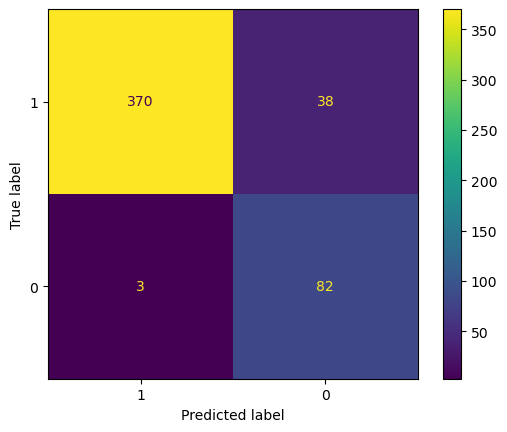

Ensemble accuracy on train set: 91.68%


In [36]:
preds, acc = evaluate_ensemble(models, X_train, y_train)
print(f"Ensemble accuracy on train set: {acc:.2%}")

Predicting...: 4it [00:00, 62.26it/s]

Accuracy of the ensemble: 0.8710
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       101
           1       0.61      0.87      0.71        23

    accuracy                           0.87       124
   macro avg       0.79      0.87      0.82       124
weighted avg       0.90      0.87      0.88       124



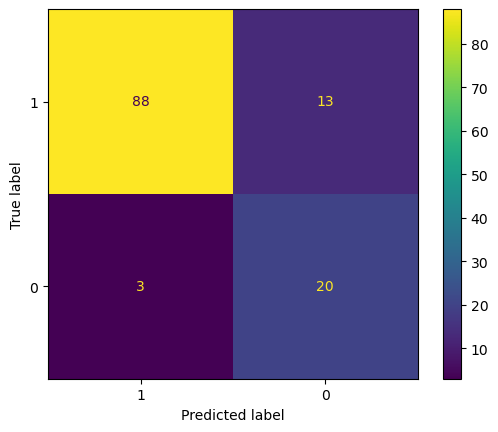

In [37]:
preds, acc = evaluate_ensemble(models, X_test, y_test)

Predicting...: 4it [00:00, 42.25it/s]


Accuracy of the ensemble: 0.9189
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       408
           1       0.70      0.94      0.80        85

    accuracy                           0.92       493
   macro avg       0.84      0.93      0.87       493
weighted avg       0.94      0.92      0.92       493



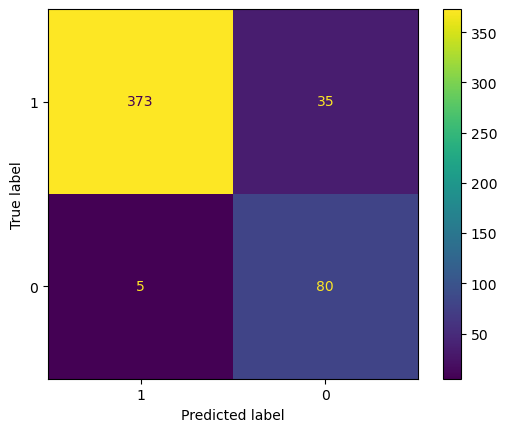

Ensemble accuracy on train set: 91.89%


Predicting...: 4it [00:00, 60.02it/s]

Accuracy of the ensemble: 0.8790
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       101
           1       0.63      0.83      0.72        23

    accuracy                           0.88       124
   macro avg       0.80      0.86      0.82       124
weighted avg       0.90      0.88      0.88       124



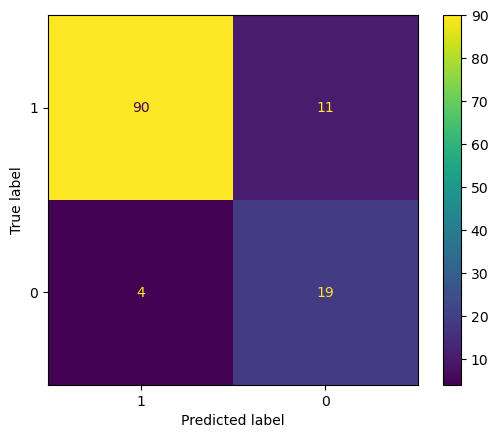

In [38]:
preds, acc = evaluate_ensemble(models, X_train, y_train, voting="hard")
print(f"Ensemble accuracy on train set: {acc:.2%}")
preds, acc = evaluate_ensemble(models, X_test, y_test, voting="hard")

In [39]:
def predict_ensemble(models, X):
    """Predicts the probability of the positive class for an ensemble of models.

    Parameters
    ----------
    models : list of models
        The list of models to evaluate.
    X : array-like of shape (n_samples, n_features)
        The input samples.
    Returns
    -------
    preds : ndarray of shape (n_samples,2)
        The ensemble predictions.
    """
    # Initialize an array to store the predictions for each model
    preds = np.zeros((len(models), len(X), 2))

    # Make predictions for each model
    for i, model in tqdm(enumerate(models), "Predicting..."):
        preds[i] = model.predict_proba(X)
    preds = np.mean(preds, axis=0)

    return preds

In [40]:
# test_preds = predict_ensemble(models, test_final)
test_preds = vc.predict_proba(test_final)

In [41]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[["class_0", "class_1"]] = test_preds
sample_submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.841378,0.158622
1,010ebe33f668,0.841378,0.158622
2,02fa521e1838,0.841378,0.158622
3,040e15f562a2,0.841378,0.158622
4,046e85c7cc7f,0.841378,0.158622


In [42]:
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)